In [1]:
import warnings
warnings.filterwarnings('ignore')
import squidpy as sq
import pandas as pd
import anndata as ad
import scanpy as sc
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

Validation errors in config file(s).
The following fields have been reset to the default value:

schema_version
  value is not a valid tuple (type=type_error.tuple)



<h1> Niche calculations </h1>

load example data with cell type annotation:

In [2]:
adata = sq.datasets.seqfish()

Every niche method requires a spatial neighborhood graph, which is why `sq.gr.spatial_neighbors` needs to be run first.

In [3]:
sq.gr.spatial_neighbors(adata, coord_type="generic", percentile=99, delaunay=False, n_neighs=5)

Let's begin with the neighborhood profile clustering approach. Here we first build the neighborhood profile:

In [4]:
sq.gr.calculate_niche(adata, groups="celltype_mapped_refined", flavor="neighborhood")

Which is now stored in `.obsm`

In [5]:
adata

AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined'
    uns: 'celltype_mapped_refined_colors', 'spatial_neighbors'
    obsm: 'X_umap', 'spatial', 'neighborhood_profile'
    obsp: 'spatial_connectivities', 'spatial_distances'

For further processing we turn the neighborhood profile into an `AnnData` object

In [5]:
adata_nhood = ad.AnnData(X=adata.obsm["neighborhood_profile"])

In [7]:
adata_nhood

AnnData object with n_obs × n_vars = 19416 × 22

In [8]:
adata_nhood.X

array([[0.2, 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , ..., 0.6, 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

Run PCA, nearest neighbors and Leiden clustering:

In [6]:
sc.pp.pca(adata_nhood)
sc.pp.neighbors(adata_nhood)
sc.tl.leiden(adata_nhood)

Move the result back into our original data.

In [7]:
adata.obs["neighbor_niche"] = adata_nhood.obs["leiden"]

Visualize the result by comparing it to the cell type annotation:

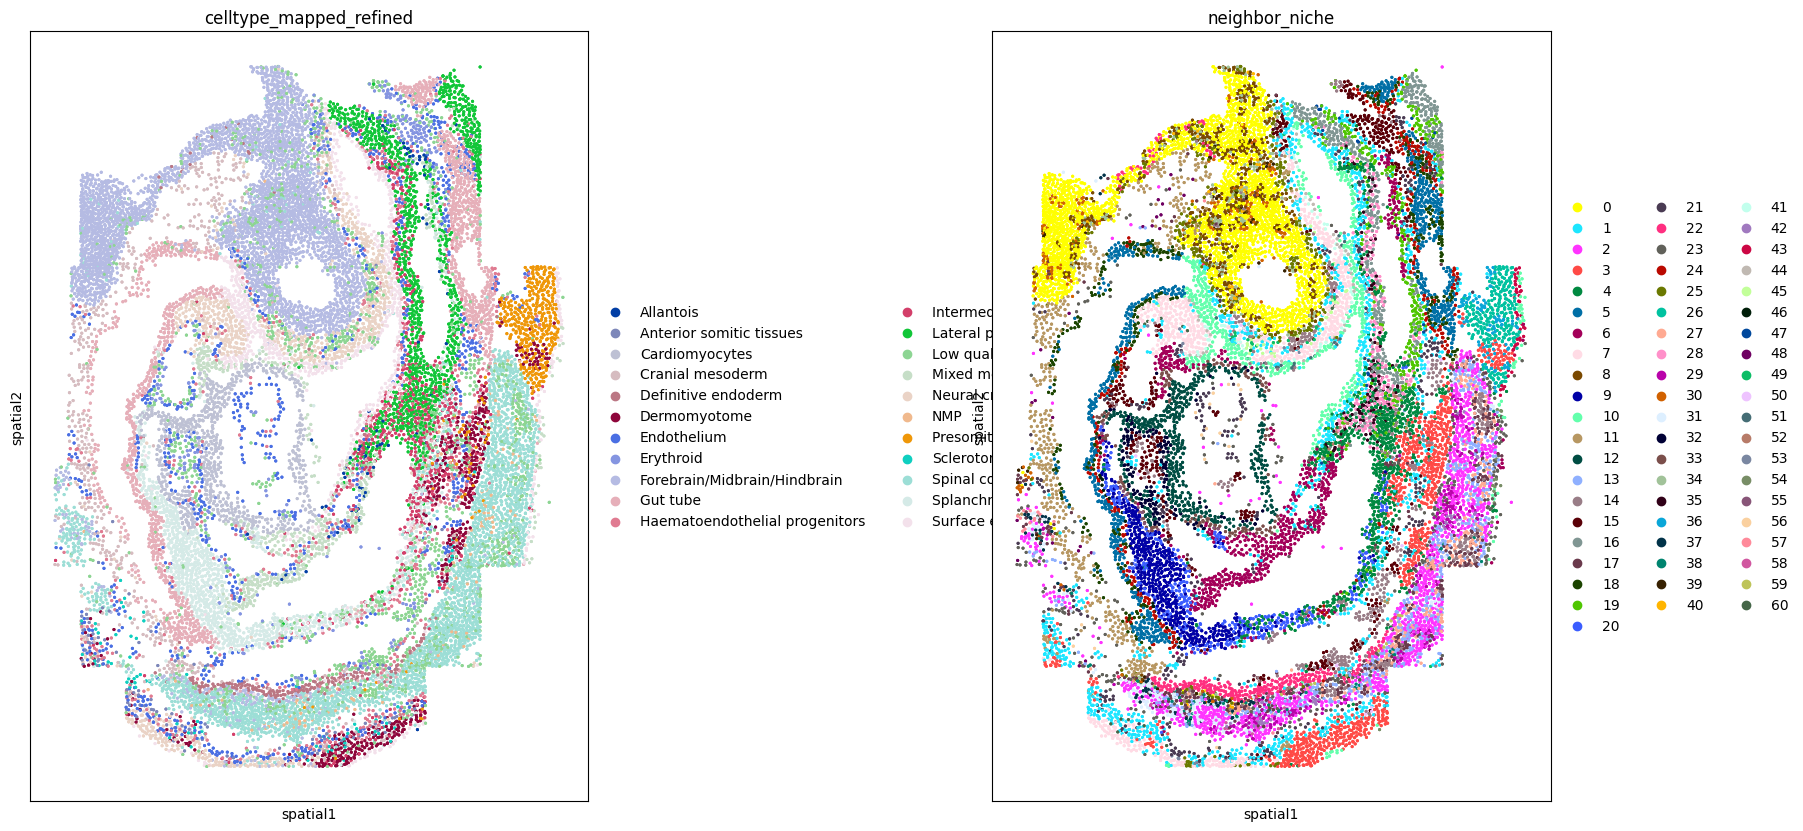

In [8]:
sq.pl.spatial_scatter(
    adata, color=["celltype_mapped_refined","neighbor_niche"], shape=None, figsize=(10, 10)
)

<h1> UTAG </h1>
Next we follow the UTAG approach, which involves the count matrix stored in adata.X.

In [12]:
sq.gr.calculate_niche(adata, groups="celltype_mapped_refined", flavor="utag")

The new count matrix is stored in a different layer.

In [13]:
adata.layers["utag"]

<19416x351 sparse matrix of type '<class 'numpy.float64'>'
	with 4411029 stored elements in Compressed Sparse Row format>

Proceed as before during the neighborhood approach.

In [14]:
sc.pp.pca(adata, layer="utag")
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.leiden(adata, neighbors_key="neighbors")
adata.obs["utag_niche"] = adata.obs["leiden"]

Visualize the result:

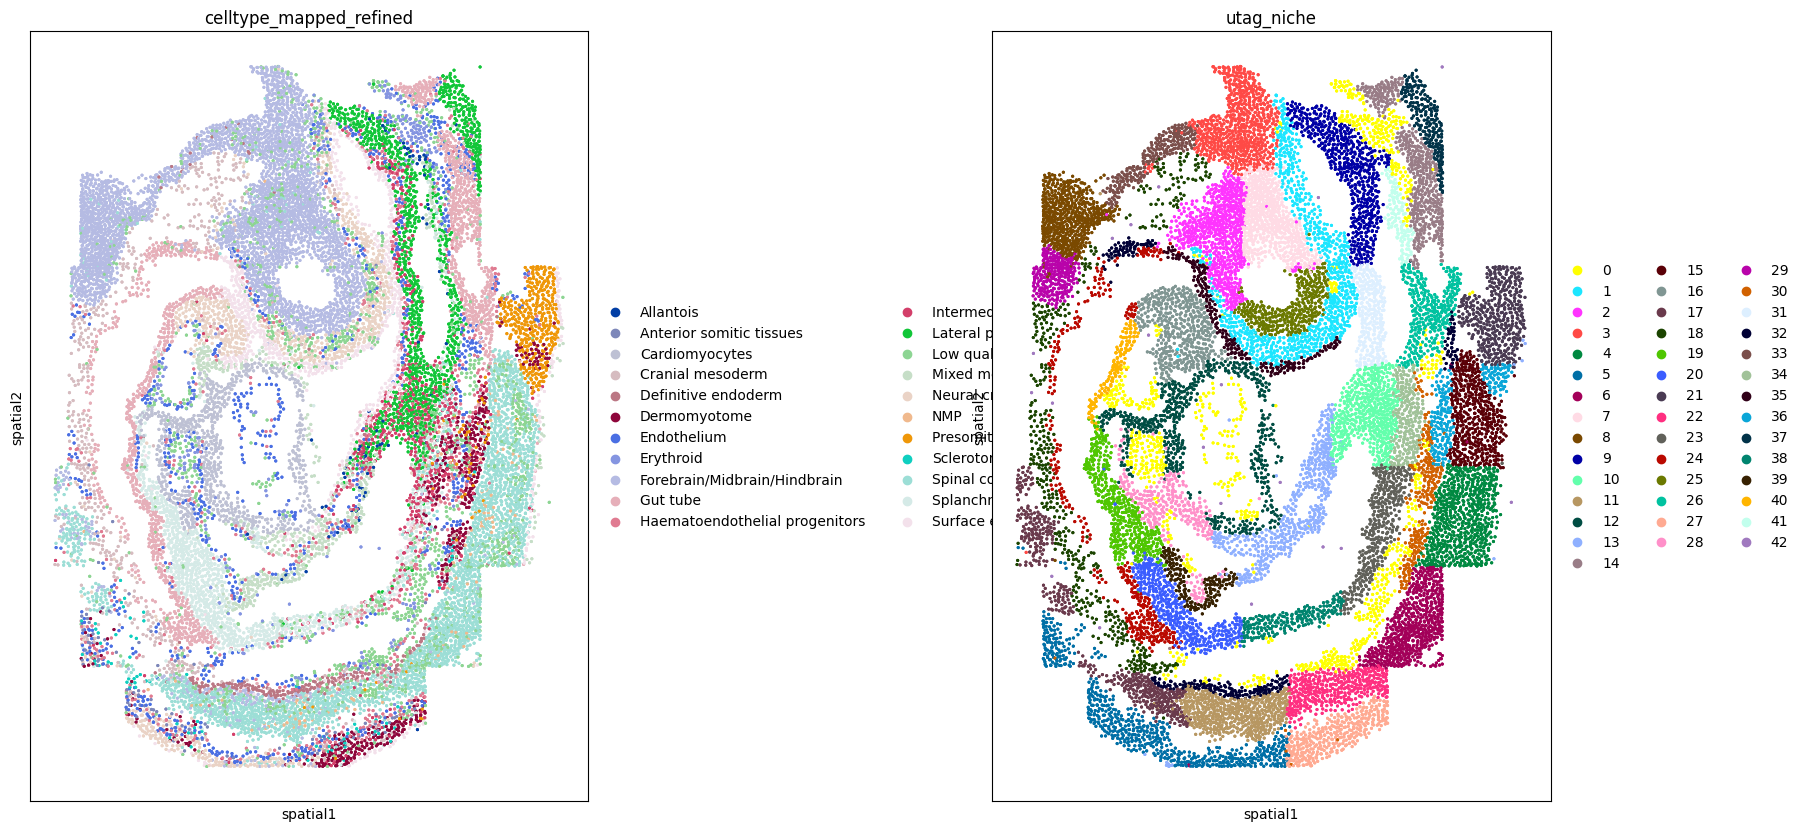

In [15]:
sq.pl.spatial_scatter(
    adata, color=["celltype_mapped_refined","utag_niche"], shape=None, figsize=(10, 10)
)

For comparison we also cluster our count data without including spatial information:

In [16]:
sc.pp.pca(adata)
sc.pp.neighbors(adata, use_rep="X_pca")
sc.tl.leiden(adata, neighbors_key="neighbors")

Visual comparison of all clustering results:

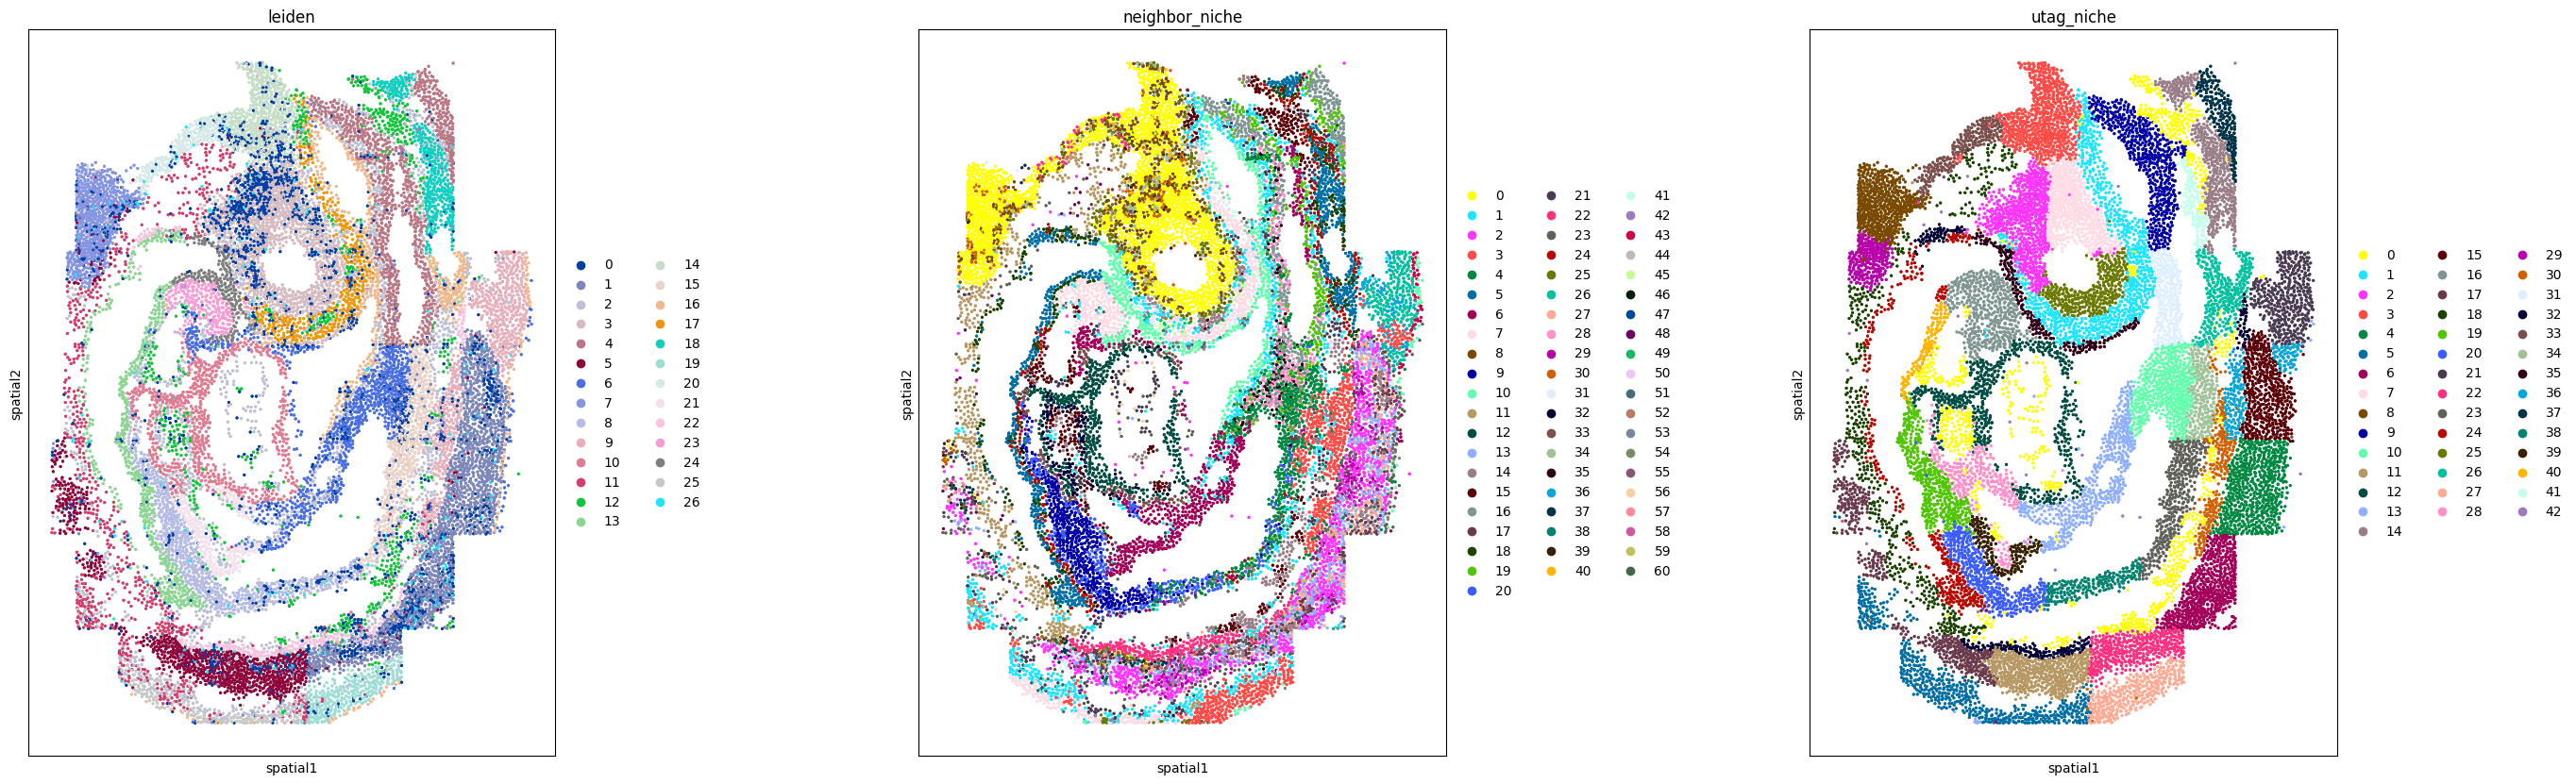

In [17]:
sq.pl.spatial_scatter(
    adata, color=["leiden", "neighbor_niche", "utag_niche",], shape=None, figsize=(10, 10)
)

Let's compare these results with some scores, to see how much they align with each other:

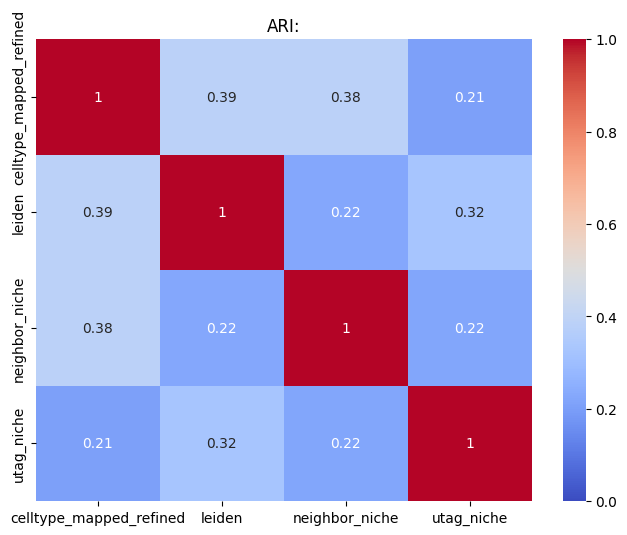

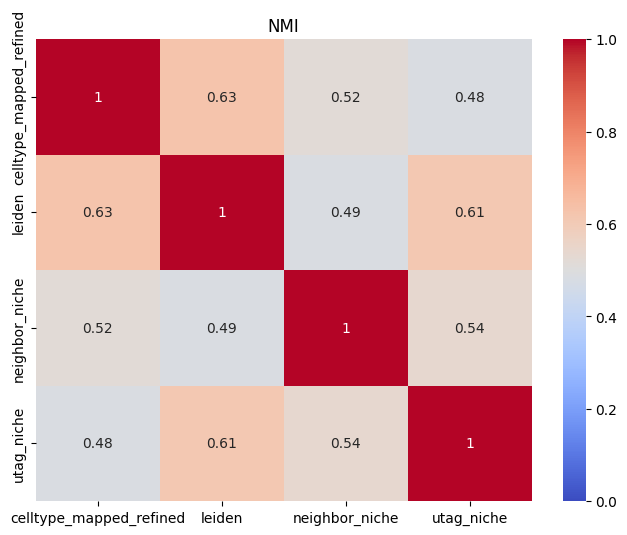

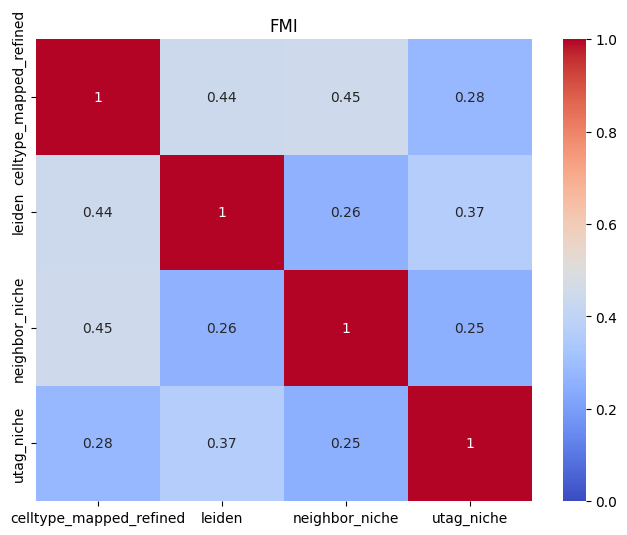

In [18]:
niche_definitions = ["celltype_mapped_refined", "leiden", "neighbor_niche", "utag_niche"]
result = pd.DataFrame(index=niche_definitions, columns=niche_definitions, data=None, dtype=float)
combinations = list(itertools.combinations_with_replacement(niche_definitions, 2))
scores = {"ARI:": adjusted_rand_score, "NMI": normalized_mutual_info_score, "FMI": fowlkes_mallows_score}
for score_name, score_func in scores.items():
    for pair in combinations:
        score = score_func(adata.obs[pair[0]], adata.obs[pair[1]])
        result.at[pair[0], pair[1]] = score
        result.at[pair[1], pair[0]] = score
    plt.figure(figsize=(8, 6))
    sns.heatmap(result, annot=True, cmap='coolwarm', vmin=0, vmax=1)
    plt.title(score_name)
    plt.show

For the Cellcharter approach, we can calculate the matrix which is later used for clustering. In their paper they used GMMs.

In [19]:
sq.gr.calculate_niche(adata, groups="celltype_mapped_refined", flavor="cellcharter", adj_subsets=[0,1,3])

The "Adj_n" after each var name refers to the n-neighbors adjacency matrix.

In [20]:
adata.obsm["cellcharter_niche"]

Abcc4_Adj_0  Acp5_Adj_0  Acvr1_Adj_0  Acvr2a_Adj_0  \
embryo1_Pos0_cell10_z2           0.0         5.0          4.0           4.0   
embryo1_Pos0_cell10_z5           1.0         0.0          0.0           2.0   
embryo1_Pos0_cell100_z2          0.0         6.0          0.0           0.0   
embryo1_Pos0_cell100_z5          0.0         1.0          2.0           2.0   
embryo1_Pos0_cell101_z2          0.0         6.0          0.0           0.0   
...                              ...         ...          ...           ...   
embryo1_Pos28_cell97_z2          4.0         7.0          1.0           4.0   
embryo1_Pos28_cell97_z5          1.0         4.0          2.0           0.0   
embryo1_Pos28_cell98_z2          2.0         2.0          0.0           2.0   
embryo1_Pos28_cell98_z5          0.0         1.0          0.0           0.0   
embryo1_Pos28_cell99_z5          0.0         0.0          0.0           2.0   

                         Adora2b_Adj_0  Afp_Adj_0  Ahnak_Adj_0  Akr1c19_Adj_0  \
embryo1_Pos0_cell10_z2             0.0        1.0          4.0            3.0   
embryo1_Pos0_cell10_z5             0.0        1.0          2.0            7.0   
embryo1_Pos0_cell100_z2            0.0        0.0          1.0            0.0   
embryo1_Pos0_cell100_z5            0.0        0.0          0.0           13.0   
embryo1_Pos0_cell101_z2            0.0        0.0          0.0            2.0   
...                                ...        ...          ...            ...   
embryo1_Pos28_cell97_z2            2.0        2.0          5.0           12.0   
embryo1_Pos28_cell97_z5            0.0        1.0          0.0            0.0   
embryo1_Pos28_cell98_z2            2.0        1.0          3.0            8.0   
embryo1_Pos28_cell98_z5            0.0        1.0          0.0            1.0   
embryo1_Pos28_cell99_z5            1.0        0.0          1.0            1.0   

                         Alas2_Adj_0  Aldh1a2_Adj_0  ...  Wnt2b_Adj_3  \
embryo1_Pos0_cell10_z2           2.0            6.0  ...          0.0   
embryo1_Pos0_cell10_z5           0.0            3.0  ...          0.0   
embryo1_Pos0_cell100_z2         13.0            0.0  ...          0.0   
embryo1_Pos0_cell100_z5          4.0            3.0  ...          0.0   
embryo1_Pos0_cell101_z2         11.0            0.0  ...          0.0   
...                              ...            ...  ...          ...   
embryo1_Pos28_cell97_z2          0.0            3.0  ...          0.0   
embryo1_Pos28_cell97_z5         13.0           29.0  ...          0.0   
embryo1_Pos28_cell98_z2          1.0            5.0  ...          0.0   
embryo1_Pos28_cell98_z5          4.0           27.0  ...          0.0   
embryo1_Pos28_cell99_z5          0.0            7.0  ...          0.0   

                         Wnt3_Adj_3  Wnt3a_Adj_3  Wnt5a_Adj_3  Wnt5b_Adj_3  \
embryo1_Pos0_cell10_z2          0.0          0.0          0.0          0.0   
embryo1_Pos0_cell10_z5          0.0          0.0          0.0          0.0   
embryo1_Pos0_cell100_z2         0.0          0.0          0.0          0.0   
embryo1_Pos0_cell100_z5         0.0          0.0          0.0          0.0   
embryo1_Pos0_cell101_z2         0.0          0.0          0.0          0.0   
...                             ...          ...          ...          ...   
embryo1_Pos28_cell97_z2         0.0          0.0          0.0          0.0   
embryo1_Pos28_cell97_z5         0.0          0.0          0.0          0.0   
embryo1_Pos28_cell98_z2         0.0          0.0          0.0          0.0   
embryo1_Pos28_cell98_z5         0.0          0.0          0.0          0.0   
embryo1_Pos28_cell99_z5         0.0          0.0          0.0          0.0   

                         Wnt8a_Adj_3  Xist_Adj_3  Zfp444_Adj_3  Zfp57_Adj_3  \
embryo1_Pos0_cell10_z2           0.0         0.0           0.0          0.0   
embryo1_Pos0_cell10_z5           0.0         0.0           0.0          0.0   
embryo1_Pos0_cell100_z2          0.0         0.0    